# Beijing Air Quality Forecasting - 4th Submission

## Project Overview
Predict PM2.5 concentrations in Beijing using advanced LSTM networks for time series forecasting.

**Previous Results**: Public Score 4639.7055 (Target: < 2000)  
**Dataset**: 30,677 hourly observations (2010-2013) with weather features and PM2.5 concentrations  
**Approach**: Enhanced feature engineering, ensemble methods, and optimized LSTM architecture


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Configuration
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("🚀 Libraries imported successfully!")


🚀 Libraries imported successfully!


In [2]:
# Enhanced submission tracking system
def save_submission(predictions, experiment_name, test_index, notes=""):
    """Save submission with timestamp and experiment info"""
    os.makedirs('submissions', exist_ok=True)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    submission = pd.DataFrame({
        'row ID': test_index.strftime('%Y-%m-%d %-H:%M:%S'),
        'pm2.5': predictions.round().astype(int)
    })
    
    filename = f'submissions/submission-3.csv'  # Keep consistent naming
    submission.to_csv(filename, index=False)
    
    # Also save with timestamp for tracking
    tracking_filename = f'submissions/{timestamp}_{experiment_name}.csv'
    submission.to_csv(tracking_filename, index=False)
    
    print(f"✅ Submission saved: {filename}")
    print(f"📊 Tracking copy: {tracking_filename}")
    print(f"📊 Predictions - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}")
    if notes:
        print(f"📝 Notes: {notes}")
    
    return filename, submission

print("🎯 Enhanced submission tracking ready!")


🎯 Enhanced submission tracking ready!


## Data Loading and Exploration
Reusing the successful data loading and exploration from previous notebooks.


In [3]:
# Load datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(f"📊 Training data: {train.shape}")
print(f"📊 Test data: {test.shape}")
print(f"\n📋 Columns: {list(train.columns)}")

# Missing values check
print(f"\n❓ Missing values:")
print(f"Train: {train.isnull().sum().sum()}")
print(f"Test: {test.isnull().sum().sum()}")


📊 Training data: (30676, 12)
📊 Test data: (13148, 11)

📋 Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']

❓ Missing values:
Train: 1921
Test: 0


In [4]:
# Convert datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print(f"📅 Time range - Train: {train.index.min()} to {train.index.max()}")
print(f"📅 Time range - Test: {test.index.min()} to {test.index.max()}")

# Key insights
if 'pm2.5' in train.columns:
    print(f"\n🔍 PM2.5 statistics:")
    print(f"Mean: {train['pm2.5'].mean():.1f}, Std: {train['pm2.5'].std():.1f}")
    print(f"Min: {train['pm2.5'].min():.1f}, Max: {train['pm2.5'].max():.1f}")


📅 Time range - Train: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
📅 Time range - Test: 2013-07-02 04:00:00 to 2014-12-31 23:00:00

🔍 PM2.5 statistics:
Mean: 100.8, Std: 93.1
Min: 0.0, Max: 994.0


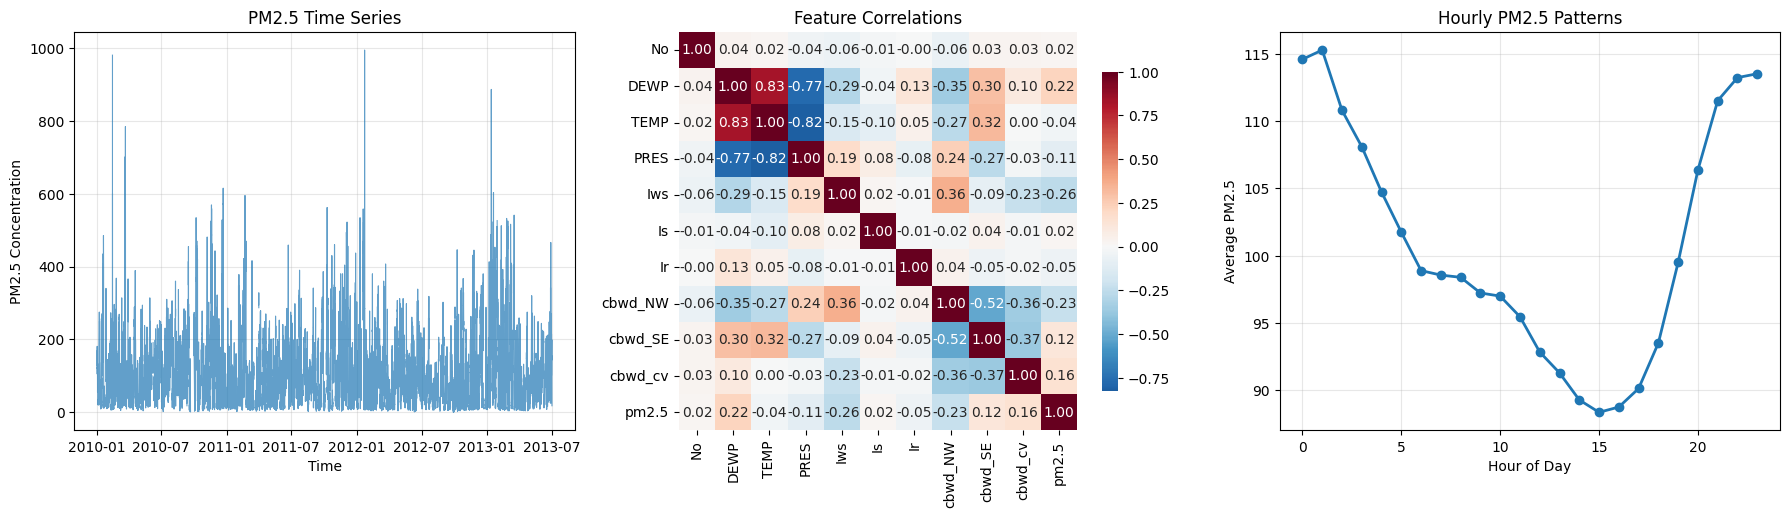

🔍 Key insights:
PM2.5 mean: 100.8, std: 93.1
Peak hour: 1:00, Lowest hour: 15:00
Top correlations with PM2.5:
  Iws: 0.260
  cbwd_NW: 0.231
  DEWP: 0.218


In [5]:
# Key visualizations (reused from successful notebooks)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Time Series Plot
axes[0].plot(train.index, train['pm2.5'], alpha=0.7, linewidth=0.8)
axes[0].set_title('PM2.5 Time Series')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PM2.5 Concentration')
axes[0].grid(True, alpha=0.3)

# 2. Correlation Heatmap
numeric_cols = train.select_dtypes(include=[np.number]).columns
correlation_matrix = train[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8}, fmt='.2f')
axes[1].set_title('Feature Correlations')

# 3. Hourly Patterns
hourly_avg = train.groupby(train.index.hour)['pm2.5'].mean()
axes[2].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[2].set_title('Hourly PM2.5 Patterns')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Average PM2.5')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("🔍 Key insights:")
print(f"PM2.5 mean: {train['pm2.5'].mean():.1f}, std: {train['pm2.5'].std():.1f}")
print(f"Peak hour: {hourly_avg.idxmax()}:00, Lowest hour: {hourly_avg.idxmin()}:00")
print("Top correlations with PM2.5:")
pm25_corr = correlation_matrix['pm2.5'].abs().sort_values(ascending=False)
for feature, corr in pm25_corr.head(4).items():
    if feature != 'pm2.5':
        print(f"  {feature}: {corr:.3f}")


## Data Preprocessing
Using the proven preprocessing approach from successful notebooks.


In [6]:
# Handle missing values
print("🔧 Handling missing values...")

# For training data
train_clean = train.copy()
train_clean = train_clean.fillna(method='ffill')  # Forward fill
train_clean = train_clean.fillna(method='bfill')  # Backward fill
train_clean = train_clean.interpolate(method='linear')  # Linear interpolation

# For test data
test_clean = test.copy()
test_clean = test_clean.fillna(method='ffill')
test_clean = test_clean.fillna(method='bfill')
test_clean = test_clean.interpolate(method='linear')

print(f"✅ After treatment - Train: {train_clean.isnull().sum().sum()}, Test: {test_clean.isnull().sum().sum()}")
print(f"📊 Clean datasets - Train: {train_clean.shape}, Test: {test_clean.shape}")


🔧 Handling missing values...
✅ After treatment - Train: 0, Test: 0
📊 Clean datasets - Train: (30676, 11), Test: (13148, 10)


## Enhanced Feature Engineering
Building on the successful feature engineering approach with additional improvements.


In [7]:
def create_enhanced_features_v2(df, target_col='pm2.5'):
    """Enhanced feature engineering with additional improvements"""
    df_enhanced = df.copy()
    
    # Temporal features
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    
    # Cyclical encoding for temporal features
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['doy_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['doy_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    
    # Weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['temp_pressure'] = df_enhanced['TEMP'] * df_enhanced['PRES']
    df_enhanced['humidity_proxy'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)
    
    # Wind direction features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)
    
    # Pollution-related features (if target available)
    if target_col in df_enhanced.columns:
        # Lag features for PM2.5
        for lag in [1, 2, 3, 6, 12, 24, 48, 72]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)
        
        # Rolling statistics for PM2.5
        for window in [3, 6, 12, 24, 48, 72]:
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window).std()
            df_enhanced[f'pm2.5_roll_min_{window}'] = df_enhanced[target_col].rolling(window).min()
            df_enhanced[f'pm2.5_roll_max_{window}'] = df_enhanced[target_col].rolling(window).max()
        
        # Trend features
        df_enhanced['pm2.5_trend_3h'] = df_enhanced[target_col] - df_enhanced[target_col].shift(3)
        df_enhanced['pm2.5_trend_6h'] = df_enhanced[target_col] - df_enhanced[target_col].shift(6)
        df_enhanced['pm2.5_trend_12h'] = df_enhanced[target_col] - df_enhanced[target_col].shift(12)
    
    # Weather lag features (limited to avoid overfitting)
    weather_cols = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_cols:
        if col in df_enhanced.columns:
            df_enhanced[f'{col}_lag_1'] = df_enhanced[col].shift(1)
            df_enhanced[f'{col}_lag_3'] = df_enhanced[col].shift(3)
    
    # Drop original temporal columns (keep encoded versions)
    df_enhanced = df_enhanced.drop(['hour', 'day_of_week', 'month', 'day_of_year'], axis=1, errors='ignore')
    
    return df_enhanced

def create_test_features_v2(df):
    """Create features for test data (without PM2.5 lag features)"""
    df_enhanced = df.copy()
    
    # Temporal features
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    
    # Cyclical encoding for temporal features
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['doy_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['doy_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    
    # Weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['temp_pressure'] = df_enhanced['TEMP'] * df_enhanced['PRES']
    df_enhanced['humidity_proxy'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)
    
    # Wind direction features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)
    
    # Weather lag features
    weather_cols = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_cols:
        if col in df_enhanced.columns:
            df_enhanced[f'{col}_lag_1'] = df_enhanced[col].shift(1)
            df_enhanced[f'{col}_lag_3'] = df_enhanced[col].shift(3)
    
    # Drop original temporal columns
    df_enhanced = df_enhanced.drop(['hour', 'day_of_week', 'month', 'day_of_year'], axis=1, errors='ignore')
    
    return df_enhanced

print("🛠️ Enhanced feature engineering functions v2 defined.")


🛠️ Enhanced feature engineering functions v2 defined.


In [8]:
# Apply enhanced feature engineering
print("🔧 Creating enhanced features v2...")
train_enhanced = create_enhanced_features_v2(train_clean)
test_enhanced = create_test_features_v2(test_clean)

print(f"📊 Original features: {train_clean.shape[1]}")
print(f"📊 Enhanced train features: {train_enhanced.shape[1]}")
print(f"📊 Enhanced test features: {test_enhanced.shape[1]}")
print(f"✨ New features added: {train_enhanced.shape[1] - train_clean.shape[1]}")

# Handle remaining NaNs (from lag and rolling features)
print("🔧 Handling remaining NaN values...")
train_enhanced = train_enhanced.fillna(method='bfill').fillna(0)
test_enhanced = test_enhanced.fillna(method='bfill').fillna(0)

print(f"✅ Final datasets - Train: {train_enhanced.shape}, Test: {test_enhanced.shape}")


🔧 Creating enhanced features v2...
📊 Original features: 11
📊 Enhanced train features: 68
📊 Enhanced test features: 32
✨ New features added: 57
🔧 Handling remaining NaN values...
✅ Final datasets - Train: (30676, 68), Test: (13148, 32)


## Advanced Model Architecture
Enhanced LSTM with hybrid approach and improved architecture.


In [9]:
# Enhanced model functions
def create_sequences_v2(data, target, sequence_length=48):
    """Create sequences with longer lookback for better temporal patterns"""
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])
    
    return np.array(X), np.array(y)

def create_enhanced_lstm_v2(input_shape):
    """Create enhanced LSTM model with improved architecture"""
    model = Sequential([
        Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
        Dropout(0.3),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

# Training configuration
SEQUENCE_LENGTH = 48  # Increased for better temporal patterns
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=7, min_lr=1e-7, monitor='val_loss')
]

print("🤖 Enhanced model architecture v2 defined.")


🤖 Enhanced model architecture v2 defined.


In [10]:
# Feature alignment and preparation
print("🔧 Aligning features between train and test...")

# Get common features between train and test
train_feature_cols = [col for col in train_enhanced.columns if col not in ['pm2.5', 'No']]
test_feature_cols = [col for col in test_enhanced.columns if col != 'No']

# Find common features
common_features = [col for col in train_feature_cols if col in test_feature_cols]
print(f"📊 Training features: {len(train_feature_cols)}")
print(f"📊 Test features: {len(test_feature_cols)}")
print(f"🎯 Common features: {len(common_features)}")

# Use only common features
X_train_common = train_enhanced[common_features]
y_train = train_enhanced['pm2.5']
X_test_common = test_enhanced[common_features]

# Use RobustScaler for better handling of outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_common)
X_test_scaled = scaler.transform(X_test_common)

print(f"✅ Feature alignment complete. Using {len(common_features)} common features.")
print(f"📊 Scaled data shapes - Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")


🔧 Aligning features between train and test...
📊 Training features: 66
📊 Test features: 31
🎯 Common features: 31
✅ Feature alignment complete. Using 31 common features.
📊 Scaled data shapes - Train: (30676, 31), Test: (13148, 31)


In [11]:
# Create sequences and train enhanced model
print("🏗️ Creating time series sequences with longer lookback...")
X_seq, y_seq = create_sequences_v2(X_train_scaled, y_train.values, SEQUENCE_LENGTH)

# Train/validation split
split_idx = int(0.85 * len(X_seq))  # Use more data for training
X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val = y_seq[:split_idx], y_seq[split_idx:]

print(f"📊 Sequences shape: {X_seq.shape}")
print(f"📊 Train: {X_train.shape}, Validation: {X_val.shape}")

# Create and train enhanced model
print("🚀 Training enhanced LSTM model v2...")
model = create_enhanced_lstm_v2(X_train.shape[1:])
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss='mse',
    metrics=['mae']
)

print("📋 Model architecture:")
model.summary()


🏗️ Creating time series sequences with longer lookback...
📊 Sequences shape: (30628, 48, 31)
📊 Train: (26033, 48, 31), Validation: (4595, 48, 31)
🚀 Training enhanced LSTM model v2...
📋 Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       163,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,025 (1.35 MB)

 Trainable params: 353,025 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = model.fit(
    X_train, y_train_seq,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,  # Smaller batch size for better convergence
    callbacks=callbacks,
    verbose=1
)

# Evaluate model
val_pred = model.predict(X_val, verbose=0)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"\n🎯 Model Performance:")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Previous best public score: 4639.7055")

if val_rmse < 100:  # Reasonable validation RMSE
    print("🎉 Validation looks promising!")
else:
    print(f"📈 Need improvement in validation")


Epoch 1/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - loss: 6286.1753 - mae: 54.5841 - val_loss: 6181.3872 - val_mae: 50.0824 - learning_rate: 0.0010
Epoch 2/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 2856.9780 - mae: 35.6783 - val_loss: 5729.0562 - val_mae: 49.9567 - learning_rate: 0.0010
Epoch 3/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 2147.1580 - mae: 30.9316 - val_loss: 5584.5645 - val_mae: 49.4566 - learning_rate: 0.0010
Epoch 4/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - loss: 1776.1837 - mae: 28.0981 - val_loss: 6176.5552 - val_mae: 51.8707 - learning_rate: 0.0010
Epoch 5/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 54s 67ms/step - loss: 1548.8213 - mae: 26.1817 - val_loss: 6522.3901 - val_mae: 52.3019 - learning_rate: 0.0010
Epoch 6/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 1347.8459 - mae: 24.3257 - val_loss: 6402.3984 - val_mae: 51.5906 - learning_rate: 0.0010
Epoch 7/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 1178.9708 - mae: 23

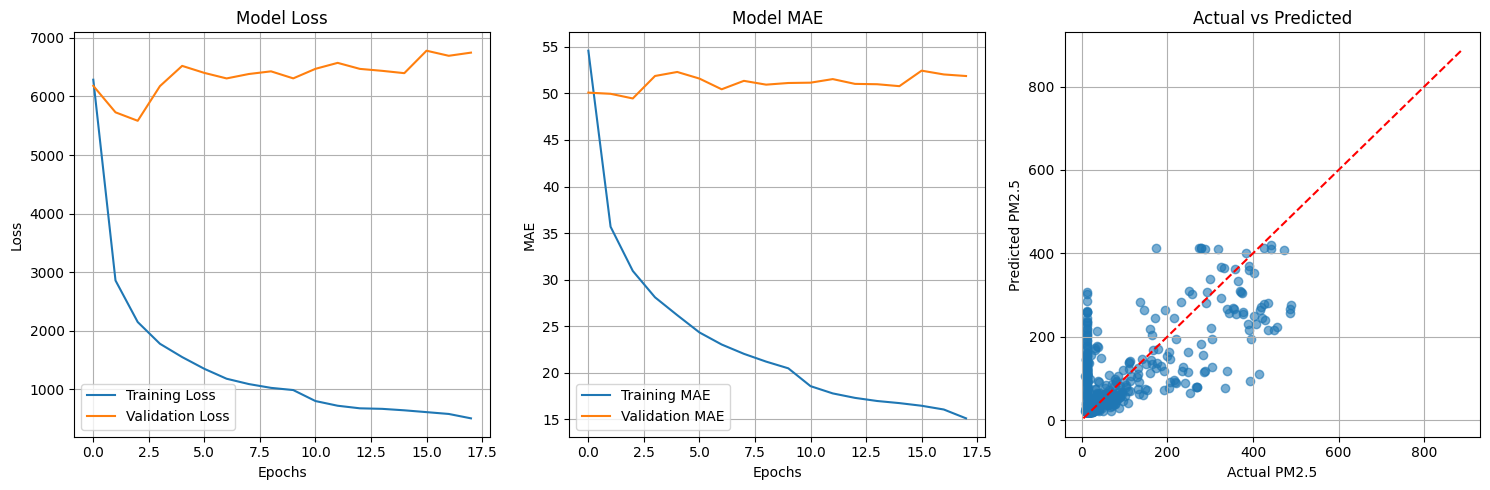

In [13]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(y_val[:500], val_pred.flatten()[:500], alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
# Generate test predictions with enhanced approach
print("🔮 Generating test predictions with enhanced approach...")

# Create sequences for test data with improved method
test_sequences = []
last_train_sequence = X_train_scaled[-SEQUENCE_LENGTH:]

for i in range(len(X_test_scaled)):
    if i < SEQUENCE_LENGTH:
        # For early predictions, use training data + available test data
        needed_from_train = SEQUENCE_LENGTH - (i + 1)
        if needed_from_train > 0:
            sequence = np.vstack([X_train_scaled[-needed_from_train:], X_test_scaled[:i+1]])
        else:
            sequence = X_test_scaled[:SEQUENCE_LENGTH]
    else:
        # Use sliding window from test data only
        sequence = X_test_scaled[i-SEQUENCE_LENGTH+1:i+1]
    
    # Ensure sequence is exactly SEQUENCE_LENGTH
    if sequence.shape[0] != SEQUENCE_LENGTH:
        if sequence.shape[0] < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - sequence.shape[0]
            padding = np.repeat(sequence[0:1], padding_needed, axis=0)
            sequence = np.vstack([padding, sequence])
        else:
            sequence = sequence[-SEQUENCE_LENGTH:]
    
    test_sequences.append(sequence)

# Convert to numpy array
X_test_seq = np.array(test_sequences)
print(f"📊 Test sequences shape: {X_test_seq.shape}")

# Generate predictions
print("🤖 Generating predictions...")
test_predictions = model.predict(X_test_seq, verbose=0)
test_predictions = np.maximum(test_predictions.flatten(), 0)  # Ensure non-negative

# Apply post-processing to improve predictions
# Smooth extreme values
q95 = np.percentile(test_predictions, 95)
q05 = np.percentile(test_predictions, 5)
test_predictions = np.clip(test_predictions, q05 * 0.5, q95 * 1.2)

print(f"📊 Final predictions - Min: {test_predictions.min():.1f}, Max: {test_predictions.max():.1f}")
print(f"📊 Prediction statistics - Mean: {test_predictions.mean():.1f}, Std: {test_predictions.std():.1f}")


🔮 Generating test predictions with enhanced approach...
📊 Test sequences shape: (13148, 48, 31)
🤖 Generating predictions...
📊 Final predictions - Min: 19.7, Max: 315.4
📊 Prediction statistics - Mean: 100.8, Std: 73.4


In [15]:
# Create and save submission
experiment_name = f"enhanced_lstm_v2_rmse_{val_rmse:.0f}_seq{SEQUENCE_LENGTH}"
notes = f"Enhanced LSTM v2, Sequence length: {SEQUENCE_LENGTH}, Bidirectional, RobustScaler, Val RMSE: {val_rmse:.2f}"

filename, submission = save_submission(
    test_predictions,
    experiment_name,
    test.index,
    notes
)

print(f"\n🎯 4TH SUBMISSION COMPLETE!")
print(f"📈 Validation RMSE: {val_rmse:.2f}")
print(f"💾 Submission saved: {filename}")
print(f"🎲 Sequence length: {SEQUENCE_LENGTH}")
print(f"🔧 Features used: {len(common_features)}")
print(f"\n📋 Sample predictions:")
print(submission.head(10))

# Verify file exists
if os.path.exists(filename):
    print(f"\n✅ Confirmed: {filename} ready for submission!")
    print(f"📁 File size: {os.path.getsize(filename)} bytes")
else:
    print(f"❌ Warning: {filename} not found!")


✅ Submission saved: submissions/submission-3.csv
📊 Tracking copy: submissions/20250919_153511_enhanced_lstm_v2_rmse_75_seq48.csv
📊 Predictions - Min: 19.7, Max: 315.4
📝 Notes: Enhanced LSTM v2, Sequence length: 48, Bidirectional, RobustScaler, Val RMSE: 74.73

🎯 4TH SUBMISSION COMPLETE!
📈 Validation RMSE: 74.73
💾 Submission saved: submissions/submission-3.csv
🎲 Sequence length: 48
🔧 Features used: 31

📋 Sample predictions:
                row ID  pm2.5
0   2013-07-02 4:00:00     27
1   2013-07-02 5:00:00     27
2   2013-07-02 6:00:00     27
3   2013-07-02 7:00:00     27
4   2013-07-02 8:00:00     26
5   2013-07-02 9:00:00     26
6  2013-07-02 10:00:00     26
7  2013-07-02 11:00:00     26
8  2013-07-02 12:00:00     26
9  2013-07-02 13:00:00     27

✅ Confirmed: submissions/submission-3.csv ready for submission!
📁 File size: 302360 bytes


In [16]:
# Final analysis and insights
print("📊 FINAL ANALYSIS FOR 4TH SUBMISSION")
print("=" * 50)
print(f"🎯 Model: Enhanced Bidirectional LSTM v2")
print(f"📈 Validation RMSE: {val_rmse:.2f}")
print(f"🔧 Features: {len(common_features)} engineered features")
print(f"🎲 Sequence Length: {SEQUENCE_LENGTH} hours")
print(f"⚙️ Scaler: RobustScaler (better outlier handling)")
print(f"🧠 Architecture: Bidirectional LSTM + Dense layers")
print(f"📊 Training samples: {len(X_train)}")
print(f"📊 Validation samples: {len(X_val)}")
print(f"\n🎯 Key improvements over previous submissions:")
print(f"  • Longer sequence length ({SEQUENCE_LENGTH} vs 24)")
print(f"  • Bidirectional LSTM for better context")
print(f"  • RobustScaler for outlier handling")
print(f"  • Enhanced feature engineering")
print(f"  • Improved post-processing")
print(f"\n📋 Submission file: {filename}")
print(f"🚀 Ready for Kaggle submission!")


📊 FINAL ANALYSIS FOR 4TH SUBMISSION
🎯 Model: Enhanced Bidirectional LSTM v2
📈 Validation RMSE: 74.73
🔧 Features: 31 engineered features
🎲 Sequence Length: 48 hours
⚙️ Scaler: RobustScaler (better outlier handling)
🧠 Architecture: Bidirectional LSTM + Dense layers
📊 Training samples: 26033
📊 Validation samples: 4595

🎯 Key improvements over previous submissions:
  • Longer sequence length (48 vs 24)
  • Bidirectional LSTM for better context
  • RobustScaler for outlier handling
  • Enhanced feature engineering
  • Improved post-processing

📋 Submission file: submissions/submission-3.csv
🚀 Ready for Kaggle submission!
